# <font color='red'>Basic Analytics Applied to Training Set of Heroes of the Storm Game Data</font>

### 1. Determine the best Heroes(in terms of win rate) in each category:
* Support
* Assassin
* Warrior
* Specialist

### 2. Determine the best Team Composition in term of win rate

### 3. Does the map affect the team composition?

### 4. Which Assassin is better; ranged or melee?

### 5. What are the most played Heroes in each category?  Are they the most likely heroes to win?


# dataset too large:
    ## reduce to only Hero League: ~1.7million lines?
    ## analyse in IPython Server? 

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys

%matplotlib inline
#using files to format dataframe display
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#load both csv files into tow respective dataframes
DF_Replay = pd.read_csv("TSReplay.csv")

DF_Characters = pd.read_csv("TSCharacters.csv")

DF_Map_Groups = pd.read_csv("HeroAndMap.csv")

In [2]:
DF_Replay.head(2)

,ReplayID,GameMode(3=Quick Match 4=Hero League 5=Team League),Map,Replay Length,Timestamp (UTC)
0,23915730,4,Haunted Mines,00:12:00,5/14/2015 12:55:26 AM
1,23927005,3,Cursed Hollow,00:21:00,5/14/2015 12:55:26 AM


In [3]:
#Renaming columns in the dataframe
DF_Replay.columns = ['ReplayID', 'GameMode', 'Map', 'ReplayLength', 'Timestamp']
#Only keeping rows relating to competitive gameplay (4 = Hero League)
DF_Replay = DF_Replay[DF_Replay['GameMode'] == 4]
DF_Replay.head(30)

,ReplayID,GameMode,Map,ReplayLength,Timestamp
0,23915730,4,Haunted Mines,00:12:00,5/14/2015 12:55:26 AM
2,23915740,4,Garden of Terror,00:26:18,5/14/2015 12:55:27 AM
10,23924385,4,Garden of Terror,00:34:37,5/14/2015 12:55:39 AM
22,23915858,4,Sky Temple,00:22:32,5/14/2015 12:56:00 AM
23,23915915,4,Dragon Shire,00:24:00,5/14/2015 12:56:01 AM
25,24393574,4,Garden of Terror,00:20:15,5/14/2015 12:56:08 AM
30,23929877,4,Dragon Shire,00:22:01,5/14/2015 12:56:13 AM
31,23950711,4,Blackheart's Bay,00:16:45,5/14/2015 12:56:13 AM
32,24507009,4,Garden of Terror,00:30:30,5/14/2015 12:56:14 AM
34,23915821,4,Blackheart's Bay,00:24:20,5/14/2015 12:56:15 AM


In [4]:
#Split the string for ReplayLength into several sub-cells based on the ':'
# XX : YY : ZZ
# X *60 *60 (for float(sec))
# Y *1 *60  (for float(sec))
# Z *1      (for float(sec))

#from format   |  hh:mm:mm  |
#to format     |  hh  |  :  | mm:ss  |
ChangeTime = DF_Replay['ReplayLength'].str.partition(':')
ChangeTime.columns = ['Hour', 'Col2', 'MinSec']
#Now we have one column for hours, and one for both minutes and seconds to partition again

#from format  |  mm:ss  |
#to format    |  mm  |  :  |  ss  |
ChangeTime2 = ChangeTime['MinSec'].str.partition(':')
ChangeTime2.columns = ['Min', 'Space', 'Second']
#now we have one column for minutes and one for seconds

#Get both column in float type
ChangeTime2['Min'] = ChangeTime2['Min'].astype(float)
ChangeTime2['Second'] = ChangeTime2['Second'].astype(float)

#Apply math to convert min to sec, then add minutes and seconds together
ChangeTime2['Min']= ChangeTime2['Min'] * 60
ChangeTime2['Second'] = ChangeTime2['Min'] + ChangeTime2['Second']
ChangeTime2 = ChangeTime2[[2]]

ChangeTime = ChangeTime.drop('MinSec', axis=1)
ChangeTime['Hour'] = ChangeTime['Hour'].astype(float)
#change the values in the column with *60 to get in minutes, and *60 again to get result in seconds
ChangeTime['Hour'] = ChangeTime['Hour'] * 60 * 60     

ChangeTime['Col2'] = (ChangeTime2['Second'] + ChangeTime['Hour'])

DF_Replay['ReplayLength'] = ChangeTime['Col2']
DF_Replay.head()

,ReplayID,GameMode,Map,ReplayLength,Timestamp
0,23915730,4,Haunted Mines,720,5/14/2015 12:55:26 AM
2,23915740,4,Garden of Terror,1578,5/14/2015 12:55:27 AM
10,23924385,4,Garden of Terror,2077,5/14/2015 12:55:39 AM
22,23915858,4,Sky Temple,1352,5/14/2015 12:56:00 AM
23,23915915,4,Dragon Shire,1440,5/14/2015 12:56:01 AM


In [5]:
DF_Characters.head()

,ReplayID,Is Auto Select,Hero,Hero Level,Is Winner,MMR Before
0,23915730,False,Rehgar,14,False,3170
1,23915730,False,Falstad,10,False,3330
2,23915730,False,Jaina,7,True,3442
3,23915730,False,Sylvanas,13,False,2666
4,23915730,False,Zagara,10,True,3198


In [6]:
DF_Map_Groups.head(2)

,ID,Name,Group,SubGroup
0,0,Unknown,NaN,NaN
1,1,Abathur,Specialist,Utility


In [7]:
#Remove all after row 49, to remove map IDs and keep all data for Heroes
DF_Map_Groups = DF_Map_Groups[:48]

#DF3 = DF.drop('ID', axis=1).drop('SubGroup', axis=1)
DF_Map_Groups = DF_Map_Groups.drop('SubGroup', axis=1).drop('ID', axis=1)

#Returning last 3 elements to check
DF_Map_Groups.iloc[45:]

,Name,Group
45,Gall,Assassin
46,Lunara,Assassin
47,Greymane,Assassin


In [8]:
#Need to merge on 'ReplayID' and duplicate entries
from pandas import merge
DF1 = pd.merge(DF_Replay, DF_Characters, left_on=["ReplayID"], right_on=['ReplayID'], how='left')
DF1.head(4)

#deleting previous dataframes created for memory reasons
del DF_Replay
del DF_Characters

In [9]:
#Need to merge on 'Name' 
DF = pd.merge(DF1, DF_Map_Groups, left_on=["Hero"], right_on=["Name"], how='left')

#delete the former dataframe DF_Map_Groups for memory's optimization
del DF_Map_Groups
del DF1

In [10]:
#Saving the merged Dataframe to a csv file
DF.to_csv("HeroLeagueData.csv")

In [11]:
DataFrame = pd.read_csv("HeroLeagueData.csv")
del DF
DataFrame.head()

,Unnamed: 0,ReplayID,GameMode,Map,ReplayLength,Timestamp,Is Auto Select,Hero,Hero Level,Is Winner,MMR Before,Name,Group
0,0,23915730,4,Haunted Mines,720,5/14/2015 12:55:26 AM,False,Rehgar,14,False,3170,Rehgar,Support
1,1,23915730,4,Haunted Mines,720,5/14/2015 12:55:26 AM,False,Falstad,10,False,3330,Falstad,Assassin
2,2,23915730,4,Haunted Mines,720,5/14/2015 12:55:26 AM,False,Jaina,7,True,3442,Jaina,Assassin
3,3,23915730,4,Haunted Mines,720,5/14/2015 12:55:26 AM,False,Sylvanas,13,False,2666,Sylvanas,Specialist
4,4,23915730,4,Haunted Mines,720,5/14/2015 12:55:26 AM,False,Zagara,10,True,3198,Zagara,Specialist


In [12]:
#drop these columns from dataframe as they are no longer relevant
DataFrame = DataFrame.drop('Unnamed: 0', axis=1).drop('GameMode', axis=1).drop('Name', axis=1).drop('Is Auto Select', axis=1).drop('Timestamp', axis=1)


#Overwrite the DataFrame's Column names to get it into correct format for future use
DataFrame.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group']
#similar to:
#DF = DF.rename(columns = ('Replay Length':'ReplayLength'))
#DF = DF.rename(columns = {'Timestamp (UTC)':'Timestamp'})
#DF = DF.rename(columns = {'Is Auto Select':'AutoSelect'})
#...

list(DataFrame.columns.values)

['ReplayID',
 'Map',
 'ReplayLength',
 'Hero',
 'HeroLevel',
 'IsWinner',
 'MMRbefore',
 'Group']

In [13]:
DataFrame.dtypes 
#ReplayID          int64     >>>Change to Category
#Map              object
#ReplayLength     object
#Hero             object
#HeroLevel         int64
#IsWinner           bool
#MMRBefore       float64
#Group            object

ReplayID          int64
Map              object
ReplayLength    float64
Hero             object
HeroLevel         int64
IsWinner           bool
MMRbefore       float64
Group            object
dtype: object

In [14]:
# Check if any fields contain null values
DataFrame.isnull().sum()

ReplayID             0
Map                  0
ReplayLength         0
Hero                 0
HeroLevel            0
IsWinner             0
MMRbefore       175460
Group                0
dtype: int64

In [15]:
# Remove all of the rows where the value of "MMRbefore" is not a finite number
DataFrame = DataFrame[np.isfinite(DataFrame["MMRbefore"])]

In [16]:
# Get the number of rows that have a unique value for "ReplayID"
# This value should be one tenth the value of the dataframe length, as each game has 10 players
A = DataFrame.ReplayID.nunique()
B = len(DataFrame)
print(A*10 == B)

True


In [17]:
# Find the number of entries remaining
DataFrame.shape

(1697780, 8)

In [18]:
numeric = DataFrame.select_dtypes(['int64','float64']).columns
numeric = numeric.drop("ReplayID")
DataFrame[numeric].head(5)

,ReplayLength,HeroLevel,MMRbefore
0,720,14,3170
1,720,10,3330
2,720,7,3442
3,720,13,2666
4,720,10,3198


In [19]:
DataFrame[numeric].corr()

,ReplayLength,HeroLevel,MMRbefore
ReplayLength,1.000000,-0.003705,-0.050528
HeroLevel,-0.003705,1.000000,0.103924
MMRbefore,-0.050528,0.103924,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2C5612D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0AC3DDB0>]], dtype=object)

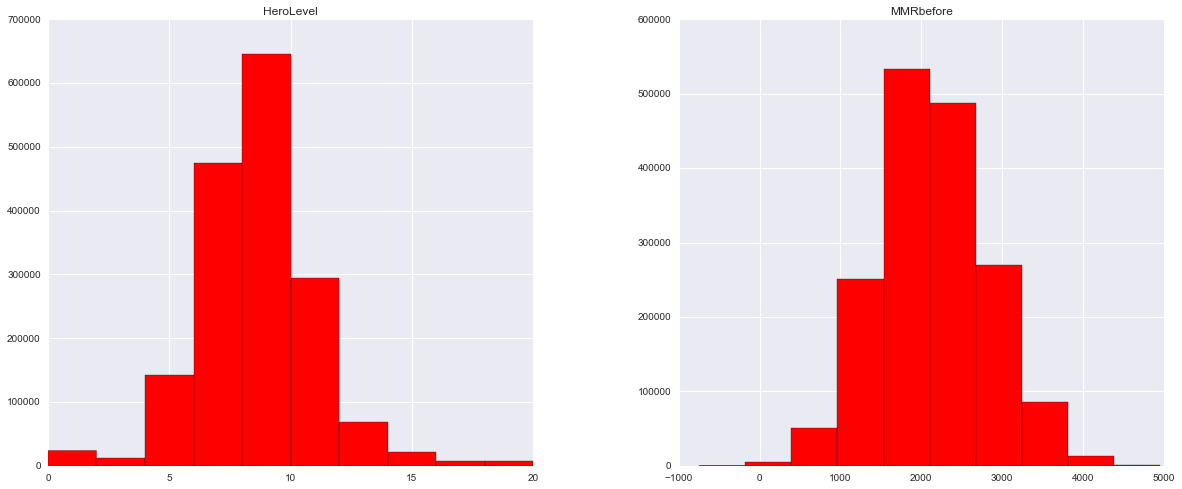

In [20]:
%matplotlib inline
DataFrame[["HeroLevel","MMRbefore"]].hist(figsize=(20, 8), color='red')
#plt.savefig("Histogram-Numeric-Features_HOTS.png")

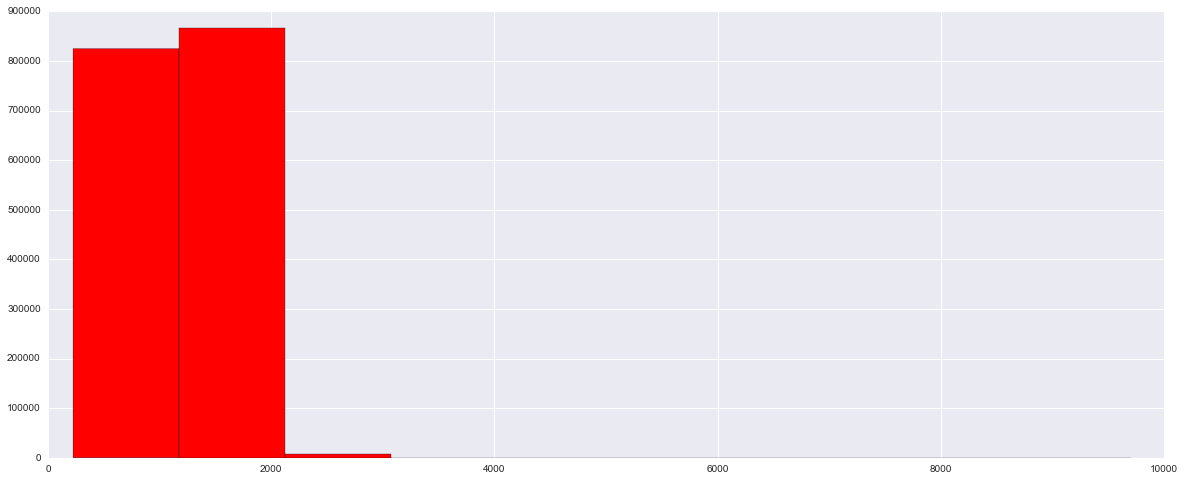

In [21]:

DataFrame["ReplayLength"].hist(figsize=(20, 8), color='red')

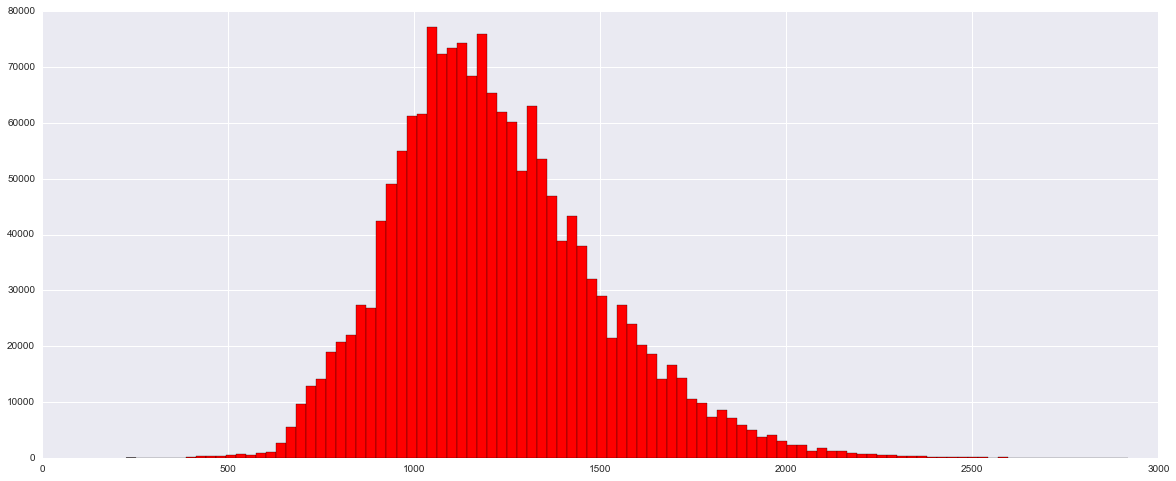

In [22]:
# Create a separate plot just to show the distribution of game length (removing lengthy outliers)
DataFrame["ReplayLength"][DataFrame.ReplayLength <= 3000].hist(figsize=(20, 8), color='red', bins=100)

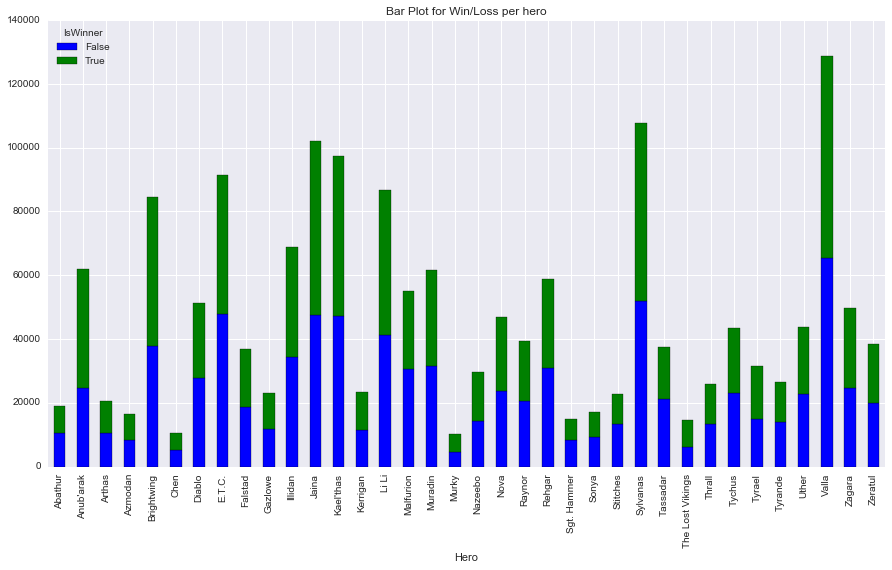

In [23]:
dfHero = DataFrame[["Hero", "IsWinner"]]
dfHero = dfHero.groupby(["Hero","IsWinner"])["Hero"].count().unstack('IsWinner')
dfHero.plot(kind="bar", stacked=True, figsize=(15,8), title="Bar Plot for Win/Loss per hero")

In [24]:

DataFrame[DataFrame.Map == 'Haunted Mines'].count()
# DataFrame[DataFrame.Map == "Sky Temple"].count()

ReplayID        243380
Map             243380
ReplayLength    243380
Hero            243380
HeroLevel       243380
IsWinner        243380
MMRbefore       243380
Group           243380
dtype: int64

#  <u> Observations </u>
According to the graph above we can identify that the Heroes which are played the most are:  
*Valla*    
*Sylvanas*    
*Jaina*  
*Kael'Thas*  
*ETC*    



    
# Define TRAIN and TEST data sets (80-20? 70-30?)
    # define model
    # look into OSL, Kernel Density Estimation
    # Linear Regression
    # logistic Regression
    
# Establish the likeliness of winning based on team rate


# How is auto-select affecting win rate?
# More/Less than Hero level??

In [25]:
DataFrame.sort_values(["ReplayID","IsWinner"],axis=0, inplace=True, ascending=[True, False])

In [26]:
DataFrame.head()

,ReplayID,Map,ReplayLength,Hero,HeroLevel,IsWinner,MMRbefore,Group
14251,23812009,Garden of Terror,814,E.T.C.,8,True,3341,Warrior
14252,23812009,Garden of Terror,814,Rehgar,10,True,3008,Support
14253,23812009,Garden of Terror,814,Raynor,10,True,2850,Assassin
14254,23812009,Garden of Terror,814,Jaina,8,True,2835,Assassin
14255,23812009,Garden of Terror,814,Sylvanas,16,True,2648,Specialist


In [27]:
# Want to extract 2 lists from each game, one from the winning team, and one from the losing team
# Each list will contain 5 items
# The list will contain the classes of characters present on that team
# E.g. Winner = ["Assassin", "Support", "Support", "Specialist", "Warrior"]
# This list should be then sorted alphabetically
# Once sorted, we should add this list as an element of another list, if it is not already contained in that list.
# This will allow us to see all of the combinations of team compositions played during our dataset
df_classes = DataFrame[["IsWinner", "ReplayID", "Group", "MMRbefore"]]

In [28]:
df_classes.shape

(1697780, 4)

In [29]:
df_classes.head()

,IsWinner,ReplayID,Group,MMRbefore
14251,True,23812009,Warrior,3341
14252,True,23812009,Support,3008
14253,True,23812009,Assassin,2850
14254,True,23812009,Assassin,2835
14255,True,23812009,Specialist,2648


In [30]:
# Initialise lists to keep track of the group of 5 classes (a.k.a. Team Composition) played in any given game
# Initialise another list to keep track of each of these lists of 5 classes
# Similar thing with MMR (a.k.a. Player Rating), but divide by 5 to get average player rating on the team
# Initialise a counter to 0, and cycle through every row in the dataframe
# The dataframe is sorted by ReplayID, so every 10 rows corresponds to 1 game
# Once counter reaches 10, reset the appropriate lists after adding their values to the larger lists

comp_win = []
comp_lose = []
composition_list = []
mmr_win = 0
mmr_lose = 0
mmr_list = []
counter = 0
for x in range(len(df_classes)):
    if df_classes.IsWinner.iloc[x] == True:
        comp_win.append(df_classes.Group.iloc[x])
        mmr_win += df_classes.MMRbefore.iloc[x]
    else:
        comp_lose.append(df_classes.Group.iloc[x])
        mmr_lose += df_classes.MMRbefore.iloc[x]
    counter += 1
    if counter == 10: # All values for a single game have been read, so now add them to lists
        comp_win.sort()
        comp_lose.sort()
        composition_list.append(comp_win)
        composition_list.append(comp_lose)
        comp_win = []
        comp_lose = []
        mmr_list.append(mmr_win//5)
        mmr_list.append(mmr_lose//5)
        mmr_win = 0
        mmr_lose = 0
        counter = 0 # Restart counter to represent next game
        
print("Finished")  

Finished


In [31]:
# From the entire list of all Team Compositions played, create a list of only the unique ones
# This can then be used to create dummies that will be used to convey what Team Composition a particular team played
# Necessary for our logisitic regression

unique_comps = []
for item in composition_list:
    if item not in unique_comps:
        unique_comps.append(item)
        
# Check that every composition conisists of 5 Classes
for j in unique_comps:
    if len(j) != 5:
        print("Error")

In [32]:
# For compositions to be easily readable, we will convert every list of 5 classes to a string representation
# A = Assassin
# S = Support
# Sp = Specialist
# W = Warrior
# For example, the string AASpWW would represent ["Assassin", "Assassin", "Specialist", "Warrior", "Warrior"]
str_comps = []
for composition in composition_list:
    string_rep = "" # String to keep track of class initials
    for character_class in composition:
        if character_class == "Specialist": # 2 classes begin with "S", so represent Specialist as "Sp"
            string_rep += character_class[0:2]
        else:
            string_rep += character_class[0]
    str_comps.append(string_rep) # Add the composition to the list
    
# Check that formatting is as expected
print(str_comps[0:5])

['AASpSW', 'AASpSW', 'AAASW', 'ASpSpSW', 'AASpSW']


In [33]:
# Create a list that can be used as a pandas Series to add as a column to our dataframe
# The ratings calculated on a per-team basis, but at the moment we still have one row per player
# Therefore, create 5 of each entry
col_rating = []
for i in mmr_list:
    col_rating.append(i)
    col_rating.append(i)
    col_rating.append(i)
    col_rating.append(i)
    col_rating.append(i)

In [34]:
# Same as the previous cell, but for team composition
col_comp = []
for i in str_comps:
    col_comp.append(i)
    col_comp.append(i)
    col_comp.append(i)
    col_comp.append(i)
    col_comp.append(i)

In [35]:
# Add these columns to the dataframe
DataFrame['Composition'] = pd.Series(col_comp, index=DataFrame.index)
DataFrame['Rating'] = pd.Series(col_rating, index=DataFrame.index)

In [36]:
DataFrame.head(20)

,ReplayID,Map,ReplayLength,Hero,HeroLevel,IsWinner,MMRbefore,Group,Composition,Rating
14251,23812009,Garden of Terror,814,E.T.C.,8,True,3341,Warrior,AASpSW,2936
14252,23812009,Garden of Terror,814,Rehgar,10,True,3008,Support,AASpSW,2936
14253,23812009,Garden of Terror,814,Raynor,10,True,2850,Assassin,AASpSW,2936
14254,23812009,Garden of Terror,814,Jaina,8,True,2835,Assassin,AASpSW,2936
14255,23812009,Garden of Terror,814,Sylvanas,16,True,2648,Specialist,AASpSW,2936
14250,23812009,Garden of Terror,814,Uther,7,False,2336,Support,AASpSW,2191
14256,23812009,Garden of Terror,814,Valla,9,False,2311,Assassin,AASpSW,2191
14257,23812009,Garden of Terror,814,Diablo,9,False,2971,Warrior,AASpSW,2191
14258,23812009,Garden of Terror,814,Sgt. Hammer,10,False,804,Specialist,AASpSW,2191
14259,23812009,Garden of Terror,814,Falstad,7,False,2535,Assassin,AASpSW,2191


In [37]:
# Create a new dataframe that is to be modified to contain only a single record per team (i.e. 2 entries per game)
DF_Teams = DataFrame[["ReplayID", "Map", "ReplayLength", "IsWinner", "Composition", "Rating"]]

In [38]:
# Perform drop on rows that do not have unqiue values for the pair "ReplayID" and "IsWinner"
DF_Teams.drop_duplicates(["ReplayID", "IsWinner"], inplace=True)
DF_Teams.head(20)

C:\Users\Romain\Anaconda3\lib\site-packages\pandas\util\decorators.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


,ReplayID,Map,ReplayLength,IsWinner,Composition,Rating
14251,23812009,Garden of Terror,814,True,AASpSW,2936
14250,23812009,Garden of Terror,814,False,AASpSW,2191
152140,23888167,Sky Temple,1022,True,AAASW,2436
152141,23888167,Sky Temple,1022,False,ASpSpSW,2280
174490,23908266,Blackheart's Bay,1671,True,AASpSW,2283
174491,23908266,Blackheart's Bay,1671,False,AAAAW,2161
163500,23908285,Tomb of the Spider Queen,810,True,AASpSW,2349
163501,23908285,Tomb of the Spider Queen,810,False,AASpSW,2292
168691,23908290,Sky Temple,1359,True,AASpSW,2252
168690,23908290,Sky Temple,1359,False,AASpSW,2504


In [39]:
# Write this to a csv file to be read as needed
DF_Teams.to_csv("Team_Info.csv")

## Beginning looking at maps

In [89]:
DataFrame.shape

(1697780, 10)

In [105]:
DataFrame.Map.unique()

array(['Garden of Terror', 'Sky Temple', "Blackheart's Bay",
       'Tomb of the Spider Queen', 'Haunted Mines', 'Dragon Shire',
       'Cursed Hollow'], dtype=object)

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Garden of Terror Map

In [107]:
GardenTerror = DataFrame[DataFrame['Map'] == 'Garden of Terror']
GardenTerror.shape

(242730, 10)

In [108]:
GardenTerror.ReplayLength.shape

(242730,)

In [109]:
# Prepare an intercept term that adds a 1 to each example.
# Scikit-learn does not use an intercept by default.
intercept = pd.DataFrame({'Intercept': np.ones(len(GardenTerror))})
intercept.head()

,Intercept
0,1
1,1
2,1
3,1
4,1


In [110]:
print(GardenTerror.shape)
GardenTerror = GardenTerror.iloc[:5000]
print(GardenTerror.shape)

# Prepare the descriptive features
X = pd.concat([intercept, GardenTerror[['IsWinner', 'Hero']]], axis=1)
y = GardenTerror.IsWinner
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

(242730, 10)
(5000, 10)
Descriptive features:
         Intercept IsWinner         Hero
0               1      NaN          NaN
1               1      NaN          NaN
2               1      NaN          NaN
3               1      NaN          NaN
4               1      NaN          NaN
5               1      NaN          NaN
6               1      NaN          NaN
7               1      NaN          NaN
8               1      NaN          NaN
9               1      NaN          NaN
10              1     True       Diablo
11              1    False       Arthas
12              1    False    Malfurion
13              1    False    Kael'thas
14              1    False      Falstad
15              1     True      Zeratul
16              1     True        Li Li
17              1     True  Sgt. Hammer
18              1     True       Tychus
19              1    False        Valla
20              1    False    Anub'arak
21              1     True    Kael'thas
22              1    False     Sy

In [111]:
#Create dummy values for Winner feature
GardenTerror_IsWinner = pd.get_dummies(GardenTerror['IsWinner'])

#GardenTerror_IsWinner.head()

Winner_new = pd.concat([GardenTerror, GardenTerror_IsWinner], axis=1)

Winner_new.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

Winner_new.head()

,ReplayID,Map,ReplayLength,Hero,HeroLevel,IsWinner,MMRbefore,Group,Composition,Rating,Loser,Winner
14251,23812009,Garden of Terror,814,E.T.C.,8,True,3341,Warrior,AASpSW,2936,0,1
14252,23812009,Garden of Terror,814,Rehgar,10,True,3008,Support,AASpSW,2936,0,1
14253,23812009,Garden of Terror,814,Raynor,10,True,2850,Assassin,AASpSW,2936,0,1
14254,23812009,Garden of Terror,814,Jaina,8,True,2835,Assassin,AASpSW,2936,0,1
14255,23812009,Garden of Terror,814,Sylvanas,16,True,2648,Specialist,AASpSW,2936,0,1


In [112]:
#import the needed module
import statsmodels.formula.api as sm

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_new[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

Optimization terminated successfully.
         Current function value: 0.692423
         Iterations 3
Intercept   -0.269772
Rating       0.000122
dtype: float64


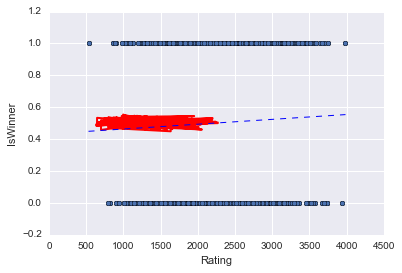

In [113]:
X_minmax = pd.DataFrame({'Rating': [Winner_new.Rating.min(), Winner_new.Rating.max()]})

predictions = logreg.predict(Winner_new)

# First, plot the observed data
Winner_new.plot(kind='scatter', x='Rating', y='IsWinner')

# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_new.ReplayLength, predictions, c='red', linewidth=2)

# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Sky Temple Map

Optimization terminated successfully.
         Current function value: 0.692016
         Iterations 3
Intercept   -0.344131
Rating       0.000152
dtype: float64


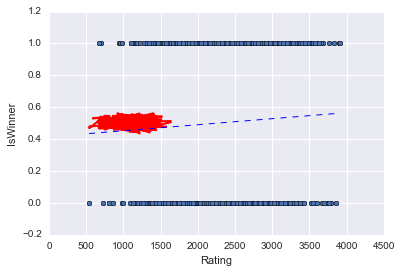

In [114]:
SkyTemple = DataFrame.loc[DataFrame['Map'] == 'Sky Temple']

intercept = pd.DataFrame({'Intercept': np.ones(len(SkyTemple))})
intercept.head()

SkyTemple = SkyTemple.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, SkyTemple[['IsWinner', 'Hero']]], axis=1)
y = SkyTemple.IsWinner

SkyTemple_IsWinner = pd.get_dummies(SkyTemple['IsWinner'])
Winner_Sky = pd.concat([SkyTemple, SkyTemple_IsWinner], axis=1)
Winner_Sky.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Sky[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Sky.Rating.min(), Winner_Sky.Rating.max()]})

predictions = logreg.predict(Winner_Sky)

# First, plot the observed data
Winner_Sky.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Sky.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Dragon Shire Map

Optimization terminated successfully.
         Current function value: 0.691720
         Iterations 4
Intercept   -0.384762
Rating       0.000172
dtype: float64


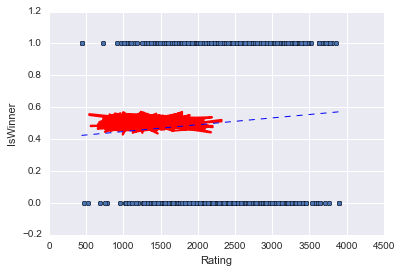

In [115]:
DragonShire = DataFrame.loc[DataFrame['Map'] == 'Dragon Shire']

intercept = pd.DataFrame({'Intercept': np.ones(len(DragonShire))})

DragonShire = DragonShire.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, DragonShire[['IsWinner', 'Hero']]], axis=1)
y = DragonShire.IsWinner

DragonShire_IsWinner = pd.get_dummies(DragonShire['IsWinner'])
Winner_Dragon = pd.concat([DragonShire, DragonShire_IsWinner], axis=1)
Winner_Dragon.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Dragon[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Dragon.Rating.min(), Winner_Dragon.Rating.max()]})

predictions = logreg.predict(Winner_Sky)

# First, plot the observed data
Winner_Dragon.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Dragon.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Blackheart's Bay Map

Optimization terminated successfully.
         Current function value: 0.692561
         Iterations 3
Intercept   -0.251046
Rating       0.000113
dtype: float64


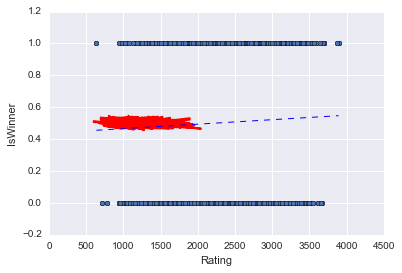

In [116]:
BlackheartsBay = DataFrame.loc[DataFrame['Map'] == "Blackheart's Bay"]

intercept = pd.DataFrame({'Intercept': np.ones(len(BlackheartsBay))})

BlackheartsBay = BlackheartsBay.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, BlackheartsBay[['IsWinner', 'Hero']]], axis=1)
y = BlackheartsBay.IsWinner

BlackheartsBay_IsWinner = pd.get_dummies(BlackheartsBay['IsWinner'])
Winner_Bay = pd.concat([BlackheartsBay, BlackheartsBay_IsWinner], axis=1)
Winner_Bay.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Bay[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Bay.Rating.min(), Winner_Bay.Rating.max()]})

predictions = logreg.predict(Winner_Bay)

# First, plot the observed data
Winner_Bay.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Bay.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Spider Queen Map

Optimization terminated successfully.
         Current function value: 0.692159
         Iterations 3
Intercept   -0.328888
Rating       0.000145
dtype: float64


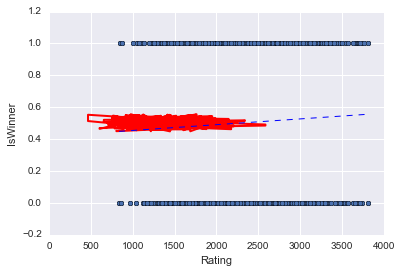

In [117]:
SpiderQueen = DataFrame.loc[DataFrame['Map'] == 'Tomb of the Spider Queen']

intercept = pd.DataFrame({'Intercept': np.ones(len(SpiderQueen))})

SpiderQueen = SpiderQueen.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, SpiderQueen[['IsWinner', 'Hero']]], axis=1)
y = SpiderQueen.IsWinner

SpiderQueen_IsWinner = pd.get_dummies(SpiderQueen['IsWinner'])
Winner_Spider = pd.concat([SpiderQueen, SpiderQueen_IsWinner], axis=1)
Winner_Spider.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Spider[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Spider.Rating.min(), Winner_Spider.Rating.max()]})

predictions = logreg.predict(Winner_Spider)

# First, plot the observed data
Winner_Spider.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Spider.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Cursed Hollow Map

Optimization terminated successfully.
         Current function value: 0.692082
         Iterations 3
Intercept   -0.344795
Rating       0.000155
dtype: float64


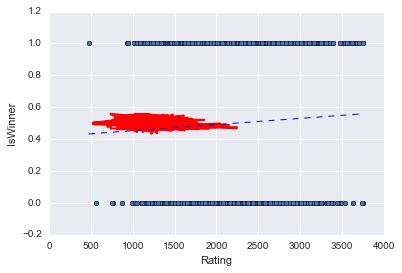

In [118]:
CursedHollow = DataFrame.loc[DataFrame['Map'] == 'Cursed Hollow']

intercept = pd.DataFrame({'Intercept': np.ones(len(CursedHollow))})

CursedHollow = CursedHollow.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, CursedHollow[['IsWinner', 'Hero']]], axis=1)
y = CursedHollow.IsWinner

CursedHollow_IsWinner = pd.get_dummies(CursedHollow['IsWinner'])
Winner_Hollow = pd.concat([CursedHollow, CursedHollow_IsWinner], axis=1)
Winner_Hollow.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Hollow[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Hollow.Rating.min(), Winner_Hollow.Rating.max()]})

predictions = logreg.predict(Winner_Hollow)

# First, plot the observed data
Winner_Hollow.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Hollow.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Haunted Mines Map

Optimization terminated successfully.
         Current function value: 0.692283
         Iterations 3
Intercept   -0.298705
Rating       0.000134
dtype: float64


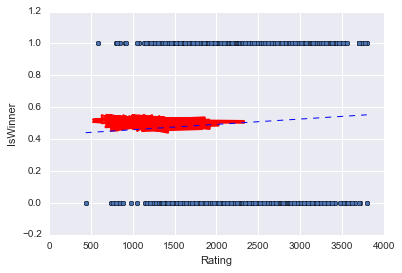

In [119]:
HauntedMines = DataFrame[DataFrame['Map'] == 'Haunted Mines']

intercept = pd.DataFrame({'Intercept': np.ones(len(HauntedMines))})

HauntedMines = HauntedMines.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, HauntedMines[['IsWinner', 'Hero']]], axis=1)
y = HauntedMines.IsWinner

HauntedMines_IsWinner = pd.get_dummies(HauntedMines['IsWinner'])
Winner_Mines = pd.concat([HauntedMines, HauntedMines_IsWinner], axis=1)
Winner_Mines.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Mines[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Mines.Rating.min(), Winner_Mines.Rating.max()]})

predictions = logreg.predict(Winner_Mines)

# First, plot the observed data
Winner_Mines.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Mines.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')